# <center> AI4LR - Final Assignment [100 Points]

In [1]:
# IMPORTANT
Your_name = "Shubh Pathak"
Your_emailid = "shubhpathakpro@gmail.com"

---

## Dataset
- Add [this dataset](https://www.kaggle.com/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset) to your Kaggle notebook.

## Instructions for this project
- Don't forget to turn on GPU for training your model(s).
- Without changing anything in the notebook if you run it then you will get the val_iou_score of around 0.20.
- Your goal of this project is to increase this val_iou_score as much as you can.
- Evaluation of this project will be based on your best acquired val_iou_score seen in the notebook.
- Your val_iou_score will be the percentage you will receive for this project. 
- If your best val_iou_score is 0.41 then you will score 41/100 points in this project.
- Try to avoid any errors before submitting your notebook.

## Tips to increase the performance of your model
- Increase the number of epochs.
- Increase the number of layers in your model.
- Using SOTA high performance networks with transfer learning.
- Using callbacks and carefully observing your model performance.
- You can use the methods taught to you in this training program or any other methods of your own choice to increase the performance!

## Guidelines on making changes to this notebook
**1)** Add a descriptive comment to your code for whatever changes you are making in this notebook.
- For example, if you are adding an extra Conv2D layer, write about all the aspects of the Conv2D layer you are adding.
- The commnt should be placed at the point where the layer will be added.

**2)** Show model properties before and after the changes were made.
- For example, if you changed the layers - added, deleted, e.t.c.

**3)** If you use new data preprocessing techniques that are not already part of this notebook, you must explain their inner workings using markdown cells.
- Without this explanation, your techniques will not be considered for evaluation.
- Use texts and images to explain this process.

**4)** Make use of tables and plots that contributed to the improvement of your model.
- Assume if increasing the epochs and decreasing the learning rate contributed in the improvement of your model.
- You will first show these improvements using plots of val_iou_scores vs epochs as well as val_iou_scores vs learning rate.0
- Then make use of tables to show iou scores for different learning rates.
- For example, table 1 for lr_1 to show iou values for epochs 30 t0 50, table 2 to show iou values from epochs 30 to 50, and so on.
- It is therefore advised to work on one improvement, optimize it, plot it, document it, then proceed to the next improvement - till you get a satisfactory IOU score.

**5)** Final improvement summary table.
- Prepare a table with columns (changes, improvments description, increase in iou from, increase in iou to)
- List out all the changes you made to improve your final model performance.

## Coding for this project

In [1]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [2]:
# import the necessary Library

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

Segmentation Models: using `keras` framework.


* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [4]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

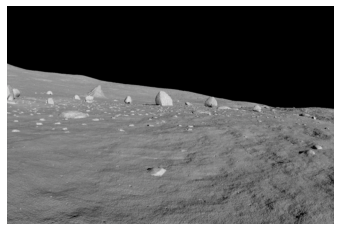

(480, 720, 3)


In [5]:
test_img = cv2.imread("../input/artificial-lunar-rocky-landscape-dataset/images/render/render0013.png")
plt.imshow(test_img)
plt.axis('off')
plt.show()
print(test_img.shape)

In [6]:
H = 480 # height of image Increased image dimension to minimise loss of information as when dimension is decreased the number of pixels where the vital feature will be present is significantly reduced
W = 480 # width of image  Increased image dimension to minimise loss of information as when dimension is decreased the number of pixels where the vital feature will be present is significantly reduced


'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(256 x 256). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [7]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [10]:
batch_size =16

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

In [68]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

'''conv_block it is used to create one block with two convolution layer 
followed by BatchNormalization and activation function relu. 
If the pooling is required then Maxpool2D is applied and return it else not.'''
# function to create convolution block
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

'''build_unet it is used to create the U-net architecture.'''
# function to build U-net
def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [69]:
# calling build_unet function
model = build_unet((480, 480, 3), 4)

#printing model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 480, 480, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 480, 480, 16) 64          conv2d_152[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 480, 480, 16) 0           batch_normalization_144[0][0]    
____________________________________________________________________________________________

## Load model and compile

In [ ]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3)#Image dimension is increased to 480X480. This is done to accomadate the height and width increase in the input image that we have changed in the previous cells above. 
num_classes = 4
lr = 1e-5 #decreased learning rate from 1e-4 to 1e-5 which gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 10#Increasing epochs will result better scores

""" Model building and compiling """
model = build_unet(img_shape, num_classes)
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr), 
              metrics=[iou_score])


train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

## Train model

In [71]:
# '''model.fit is used to train the model'''
# model_history = model.fit(train_dataset,
#         steps_per_epoch=train_steps,
#         validation_data=valid_dataset,
#         validation_steps=valid_steps,
#         epochs=epochs,
#     )

Epoch 1/10
976/976 [==============================] - 224s 228ms/step - loss: 0.7006 - iou_score: 0.0983 - val_loss: 0.5799 - val_iou_score: 0.1148
Epoch 2/10
976/976 [==============================] - 221s 226ms/step - loss: 0.5312 - iou_score: 0.1207 - val_loss: 0.5048 - val_iou_score: 0.1255
Epoch 3/10
976/976 [==============================] - 221s 227ms/step - loss: 0.4657 - iou_score: 0.1309 - val_loss: 0.4465 - val_iou_score: 0.1346
Epoch 4/10
976/976 [==============================] - 221s 226ms/step - loss: 0.4161 - iou_score: 0.1392 - val_loss: 0.3913 - val_iou_score: 0.1435
Epoch 5/10
976/976 [==============================] - 221s 227ms/step - loss: 0.3729 - iou_score: 0.1468 - val_loss: 0.3552 - val_iou_score: 0.1507
Epoch 6/10
976/976 [==============================] - 221s 226ms/step - loss: 0.3345 - iou_score: 0.1537 - val_loss: 0.3194 - val_iou_score: 0.1573
Epoch 7/10
976/976 [==============================] - 221s 227ms/step - loss: 0.3004 - iou_score: 0.1599 - val_l

# Now using Transfer Learning

### Transfer Learning - Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

![](https://www.analyticssteps.com/backend/media/thumbnail/1967565/9315476_1592890541_transfer.jpg)

In [11]:
BACKBONE = 'vgg19'#VGG is a commonly used neural network because it performs well.VGG19 has three extra convolutional layers than VGG16  which makes it a bit better for our dataset.
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

80150528/80134624 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
_____________________________

In [12]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Hyperparameters """
img_shape = (480, 480, 3) #Image dimension is increased to 480X480. This is done to accomadate the height and width increase in the input image that we have changed in the previous cells above. 
num_classes = 4
lr = 1e-5 #decreased learning rate from 1e-4 to 1e-5 which gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 15 #Increasing epochs will result better scores

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(lr), #The results of the Adam optimizer are generally better than every other optimization algorithms, have faster computation time, and require fewer parameters for tuning. Adam uses Momentum and Adaptive Learning Rates to converge faster.
               metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """
#During training, evaluation, or inference, callback is a tool that can be used to modify how a Keras model behaves.
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/AI4LR.h5'
                                           , monitor='val_iou_score', verbose=1, 
                                           mode='max', save_best_only=True), #As training progresses through the number of epochs, a callback periodically 
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), #ReduceLROnPlateau Callback keeps track of a quantity, and the learning rate is lowered if no progress is made after a certain number of "patience" epochs.
                         
             
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),# Stop training when a monitored metric has stopped improving.  
        tf.keras.callbacks.TensorBoard(f'models/logs_{current_datetime}') # Enable visualizations for TensorBoard.
]

In [13]:
# Fitting the model
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks
        )

2022-11-20 10:05:39.406795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-20 10:05:43.423276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


488/488 [==============================] - 475s 930ms/step - loss: 0.7329 - iou_score: 0.0854 - f1-score: 0.1210 - val_loss: 0.5149 - val_iou_score: 0.1270 - val_f1-score: 0.1681

Epoch 00001: val_iou_score improved from -inf to 0.12697, saving model to models/AI4LR.h5
Epoch 2/15
488/488 [==============================] - 432s 877ms/step - loss: 0.3804 - iou_score: 0.2157 - f1-score: 0.2312 - val_loss: 0.2928 - val_iou_score: 0.2341 - val_f1-score: 0.2417

Epoch 00002: val_iou_score improved from 0.12697 to 0.23407, saving model to models/AI4LR.h5
Epoch 3/15
488/488 [==============================] - 430s 881ms/step - loss: 0.2547 - iou_score: 0.2364 - f1-score: 0.2430 - val_loss: 0.1989 - val_iou_score: 0.2393 - val_f1-score: 0.2445

Epoch 00003: val_iou_score improved from 0.23407 to 0.23931, saving model to models/AI4LR.h5
Epoch 4/15
488/488 [==============================] - 429s 879ms/step - loss: 0.1791 - iou_score: 0.2392 - f1-score: 0.2445 - val_loss: 0.1471 - val_iou_score: 0.

# Observations

### Attempt 1

In [32]:
attempt1=pd.DataFrame(model_history.history)
attempt1

,loss,iou_score,val_loss,val_iou_score
0,0.261768,0.167124,0.145026,0.192275
1,0.105762,0.197626,0.077222,0.200055
2,0.075688,0.201164,0.070620,0.197366
3,0.060444,0.201117,0.055813,0.202535
4,0.049540,0.202936,0.042994,0.204104


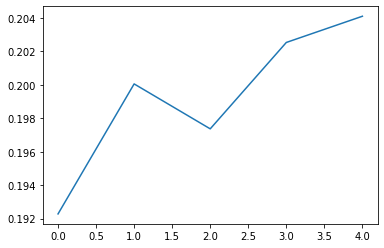

In [33]:
plt.plot(attempt1["val_iou_score"])

### Attempt 2

In [42]:
attempt2=pd.DataFrame(model_history.history)
attempt2

,loss,iou_score,val_loss,val_iou_score
0,0.315692,0.158386,0.176549,0.184030
1,0.123418,0.195357,0.089332,0.189612
2,0.072316,0.206060,0.058591,0.210640
3,0.054057,0.215478,0.053689,0.214241
4,0.038750,0.218993,0.035317,0.218500


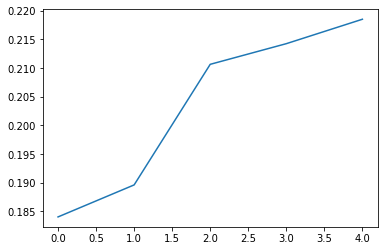

In [43]:
plt.plot(attempt2["val_iou_score"])

### Attempt 3

In [18]:
attempt3=pd.DataFrame(model_history.history)
attempt3

,loss,iou_score,val_loss,val_iou_score
0,0.287087,0.167717,0.431785,0.185368
1,0.105304,0.198371,0.082633,0.205439
2,0.064655,0.202715,0.060012,0.199156
3,0.047289,0.204714,0.043167,0.204223
4,0.032765,0.207083,0.018532,0.197834
5,0.026236,0.203147,0.037472,0.190832
6,0.021301,0.204270,0.022318,0.202593
7,0.017441,0.199522,0.013889,0.194986
8,0.016248,0.199793,0.016316,0.199305
9,0.014055,0.201522,0.014645,0.199019


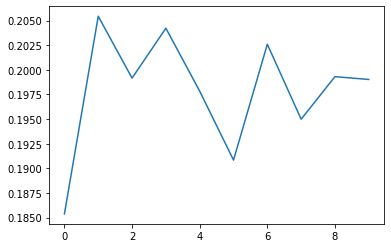

In [21]:
plt.plot(attempt3["val_iou_score"])

### Attempt 4

In [57]:
attempt4=pd.DataFrame(model_history.history)
attempt4

,loss,iou_score,val_loss,val_iou_score
0,0.594384,0.115986,0.403002,0.135341
1,0.367566,0.148354,0.305478,0.160292
2,0.231751,0.174509,0.165274,0.173365
3,0.154450,0.191554,0.109163,0.188357
4,0.106105,0.203890,0.088474,0.208127
5,0.077900,0.212569,0.052877,0.203761
6,0.065334,0.211928,0.077381,0.208674
7,0.054768,0.214454,0.045128,0.216138
8,0.045445,0.217448,0.049993,0.217293
9,0.038494,0.219312,0.062531,0.214362


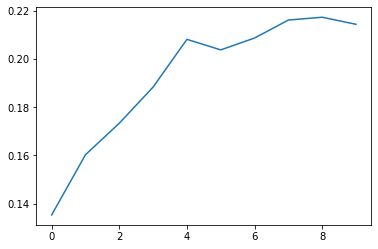

In [58]:
plt.plot(attempt4["val_iou_score"])

### Attempt 5

In [76]:
attempt5=pd.DataFrame(model_history.history)
attempt5

,loss,iou_score,val_loss,val_iou_score
0,0.700577,0.098348,0.579898,0.114778
1,0.531198,0.120741,0.504838,0.125507
2,0.465712,0.130942,0.446455,0.134582
3,0.416057,0.139235,0.391327,0.143534
4,0.372858,0.146771,0.355218,0.150716
5,0.334490,0.153673,0.319407,0.157282
6,0.300412,0.159854,0.283542,0.162811
7,0.271933,0.165083,0.264187,0.166711
8,0.254256,0.167010,0.238876,0.169725
9,0.232535,0.171000,0.222722,0.173893


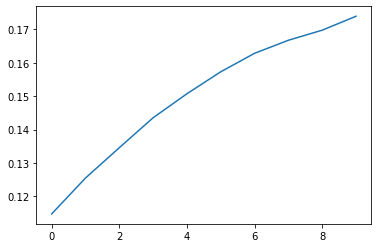

In [77]:
plt.plot(attempt5["val_iou_score"])

### Attempt 6

In [17]:
attempt6=pd.DataFrame(model_history.history)
attempt6

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,0.607243,0.173033,0.205680,0.391468,0.216479,0.235214
1,0.324951,0.297201,0.313599,0.247563,0.385800,0.395759
2,0.210224,0.467275,0.476462,0.156626,0.486343,0.492451
3,0.139128,0.488765,0.494215,0.112472,0.490514,0.495136
4,0.092459,0.490907,0.495332,0.075752,0.491375,0.495579
5,0.064632,0.491361,0.495569,0.053795,0.490811,0.495280
6,0.051665,0.491953,0.496000,0.042478,0.491688,0.495737
7,0.040665,0.492768,0.496671,0.033547,0.492068,0.495935
8,0.031396,0.492318,0.496066,0.029372,0.490431,0.495073
9,0.025211,0.495948,0.499923,0.020667,0.490566,0.496143


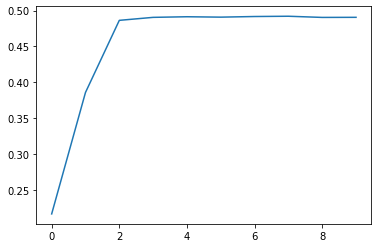

In [18]:
plt.plot(attempt6["val_iou_score"])

### Attempt 7


In [13]:
attempt7=pd.DataFrame(model_history.history)
attempt7

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,0.966555,0.014124,0.025940,0.784572,0.020249,0.037331
1,0.641687,0.087182,0.123206,0.537890,0.147046,0.184633
2,0.456417,0.178215,0.207490,0.383858,0.211781,0.233306
3,0.341947,0.220236,0.234030,0.287023,0.309267,0.319113
4,0.265755,0.233134,0.241236,0.250526,0.362039,0.369281
5,0.209751,0.237772,0.243711,0.181214,0.406893,0.412317
6,0.168558,0.244670,0.250010,0.144754,0.479384,0.484443
7,0.138131,0.255450,0.260288,0.126540,0.396185,0.400851
8,0.114804,0.281908,0.286343,0.101148,0.495427,0.499670
9,0.095749,0.303888,0.308101,0.079703,0.591038,0.596592


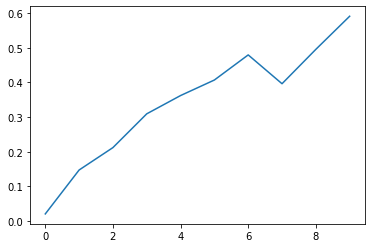

In [14]:
plt.plot(attempt7["val_iou_score"])

## Attempt 8

In [23]:
attempt8=pd.DataFrame(model_history.history)
attempt8

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score,lr
0,0.494469,0.159825,0.188460,0.301138,0.227641,0.238238,0.000010
1,0.242676,0.332634,0.339945,0.240740,0.478010,0.490169,0.000010
2,0.165489,0.696111,0.701864,0.138619,0.739578,0.744640,0.000010
3,0.110826,0.740109,0.744916,0.088366,0.741057,0.745410,0.000010
4,0.075939,0.740968,0.745366,0.061789,0.740645,0.745190,0.000010
5,0.052368,0.741471,0.745626,0.038739,0.741057,0.745413,0.000010
6,0.038352,0.741336,0.745554,0.032877,0.741322,0.745553,0.000010
7,0.029206,0.742968,0.747990,0.024737,0.736398,0.742973,0.000010
8,0.026087,0.709874,0.730962,0.023754,0.690353,0.715924,0.000010
9,0.021366,0.694721,0.718750,0.018496,0.690820,0.716243,0.000010


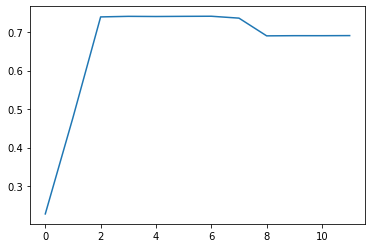

In [24]:
plt.plot(attempt8["val_iou_score"])

### Attempt 9

In [15]:
attempt9=pd.DataFrame(model_history.history)
attempt9

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score,lr
0,0.732941,0.085439,0.120977,0.514877,0.126966,0.168079,0.00001
1,0.380408,0.215686,0.231183,0.292801,0.234067,0.241749,0.00001
2,0.254687,0.236405,0.242987,0.198908,0.239311,0.244521,0.00001
3,0.179130,0.239239,0.244481,0.147052,0.244394,0.249136,0.00001
4,0.133092,0.240506,0.245141,0.115296,0.265659,0.270026,0.00001
5,0.106650,0.288447,0.292939,0.095150,0.306542,0.310954,0.00001
6,0.086505,0.423751,0.427971,0.078372,0.464856,0.469018,0.00001
7,0.067090,0.576042,0.580195,0.056153,0.638911,0.643135,0.00001
8,0.053352,0.690734,0.694916,0.047172,0.710667,0.714874,0.00001
9,0.043331,0.729290,0.733408,0.041155,0.722976,0.727178,0.00001


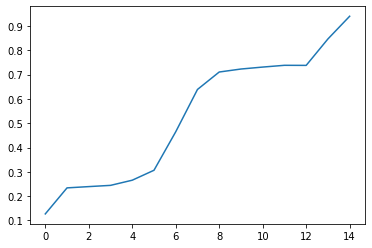

In [16]:
plt.plot(attempt9["val_iou_score"])

# Comparitive Study of all Attempts

In [22]:
history={
"his_1":{'loss': [0.2617684006690979, 0.10576216876506805, 0.07568765431642532, 0.06044408679008484, 0.04954001307487488], 'iou_score': [0.16712434589862823, 0.1976258009672165, 0.2011638730764389, 0.2011171281337738, 0.20293642580509186], 'val_loss': [0.1450260579586029, 0.07722200453281403, 0.07062003761529922, 0.05581265315413475, 0.04299436882138252], 'val_iou_score': [0.19227533042430878, 0.2000545710325241, 0.1973658800125122, 0.20253504812717438, 0.20410369336605072]}
,"his_2":{'loss': [0.31569206714630127, 0.12341804802417755, 0.07231595367193222, 0.054057080298662186, 0.03875035420060158], 'iou_score': [0.15838618576526642, 0.19535671174526215, 0.20605981349945068, 0.21547819674015045, 0.21899272501468658], 'val_loss': [0.17654937505722046, 0.08933157473802567, 0.05859103798866272, 0.053688909858465195, 0.03531716763973236], 'val_iou_score': [0.18403011560440063, 0.18961165845394135, 0.21063950657844543, 0.2142411172389984, 0.21850033104419708]}
,"his_3":{'loss': [0.28708651661872864, 0.10530440509319305, 0.0646548941731453, 0.047289133071899414, 0.03276478499174118, 0.02623555436730385, 0.021300900727510452, 0.017440592870116234, 0.016247835010290146, 0.014054697006940842], 'iou_score': [0.16771677136421204, 0.198370561003685, 0.2027149498462677, 0.2047141194343567, 0.20708298683166504, 0.2031472772359848, 0.20427049696445465, 0.19952161610126495, 0.19979263842105865, 0.2015218734741211], 'val_loss': [0.4317851662635803, 0.08263328671455383, 0.06001194193959236, 0.043167226016521454, 0.018532011657953262, 0.03747168555855751, 0.022318130359053612, 0.013888923451304436, 0.016315804794430733, 0.014644838869571686], 'val_iou_score': [0.18536804616451263, 0.2054387927055359, 0.1991557776927948, 0.20422329008579254, 0.1978335827589035, 0.1908322125673294, 0.2025929093360901, 0.19498558342456818, 0.19930481910705566, 0.19901855289936066]}
,"his_4":{'loss': [0.5943842530250549, 0.3675661087036133, 0.23175053298473358, 0.15445002913475037, 0.10610467940568924, 0.07789969444274902, 0.0653340145945549, 0.05476822704076767, 0.04544506222009659, 0.03849362954497337], 'iou_score': [0.11598598212003708, 0.14835362136363983, 0.17450867593288422, 0.19155435264110565, 0.20388951897621155, 0.21256941556930542, 0.2119280844926834, 0.2144542932510376, 0.21744805574417114, 0.219312384724617], 'val_loss': [0.4030018448829651, 0.30547818541526794, 0.16527417302131653, 0.109162837266922, 0.08847372978925705, 0.05287674441933632, 0.07738141715526581, 0.04512815177440643, 0.04999328404664993, 0.06253092736005783], 'val_iou_score': [0.13534128665924072, 0.16029155254364014, 0.17336510121822357, 0.1883571296930313, 0.20812740921974182, 0.2037612497806549, 0.208674356341362, 0.21613778173923492, 0.217292919754982, 0.2143622487783432]}
,"his_5":{'loss': [0.7005766034126282, 0.5311981439590454, 0.4657116234302521, 0.41605710983276367, 0.3728578984737396, 0.33449047803878784, 0.3004123270511627, 0.2719328999519348, 0.2542559802532196, 0.23253504931926727], 'iou_score': [0.09834833443164825, 0.12074071168899536, 0.1309419721364975, 0.13923493027687073, 0.14677143096923828, 0.15367266535758972, 0.15985436737537384, 0.16508318483829498, 0.16700999438762665, 0.17099952697753906], 'val_loss': [0.5798984169960022, 0.504838228225708, 0.44645535945892334, 0.3913270831108093, 0.3552182912826538, 0.31940728425979614, 0.2835420072078705, 0.2641867995262146, 0.23887622356414795, 0.2227216362953186], 'val_iou_score': [0.11477825045585632, 0.12550748884677887, 0.1345818042755127, 0.14353424310684204, 0.15071600675582886, 0.1572818011045456, 0.16281068325042725, 0.1667112559080124, 0.16972532868385315, 0.17389324307441711]}
,"his_6":{'loss': [0.6072426438331604, 0.32495081424713135, 0.21022357046604156, 0.1391284316778183, 0.09245886653661728, 0.06463201344013214, 0.05166522040963173, 0.04066461697220802, 0.03139606863260269, 0.025211308151483536], 'iou_score': [0.17303308844566345, 0.2972007691860199, 0.4672749638557434, 0.4887654781341553, 0.4909071624279022, 0.4913613498210907, 0.4919533431529999, 0.49276793003082275, 0.49231818318367004, 0.4959476888179779], 'f1-score': [0.20568017661571503, 0.3135991394519806, 0.4764620065689087, 0.49421459436416626, 0.4953322410583496, 0.49556905031204224, 0.4959999918937683, 0.4966714084148407, 0.4960664212703705, 0.499923437833786], 'val_loss': [0.39146843552589417, 0.2475631833076477, 0.15662634372711182, 0.11247151345014572, 0.07575240731239319, 0.05379499867558479, 0.042477697134017944, 0.03354738652706146, 0.02937193773686886, 0.02066725306212902], 'val_iou_score': [0.21647900342941284, 0.38579991459846497, 0.48634257912635803, 0.4905140995979309, 0.4913749098777771, 0.49081090092658997, 0.49168750643730164, 0.49206775426864624, 0.49043112993240356, 0.49056559801101685], 'val_f1-score': [0.23521390557289124, 0.39575883746147156, 0.4924508035182953, 0.49513623118400574, 0.49557891488075256, 0.4952799081802368, 0.4957371652126312, 0.4959350526332855, 0.4950726628303528, 0.49614256620407104]}
,"his_7":{'loss': [0.9665548801422119, 0.6416874527931213, 0.456417053937912, 0.3419467806816101, 0.265754759311676, 0.2097509652376175, 0.16855792701244354, 0.13813096284866333, 0.11480361968278885, 0.09574946761131287], 'iou_score': [0.01412388775497675, 0.08718226104974747, 0.17821502685546875, 0.2202359139919281, 0.2331342101097107, 0.23777247965335846, 0.24467022716999054, 0.25544992089271545, 0.28190818428993225, 0.3038877844810486], 'f1-score': [0.025940047577023506, 0.12320568412542343, 0.20748990774154663, 0.23402974009513855, 0.24123618006706238, 0.24371083080768585, 0.25001025199890137, 0.26028770208358765, 0.2863427698612213, 0.3081013560295105], 'val_loss': [0.7845720648765564, 0.5378904342651367, 0.3838582932949066, 0.28702297806739807, 0.25052574276924133, 0.1812140792608261, 0.14475442469120026, 0.1265403926372528, 0.10114774107933044, 0.07970298826694489], 'val_iou_score': [0.02024873159825802, 0.14704637229442596, 0.21178075671195984, 0.30926713347435, 0.3620385229587555, 0.4068925082683563, 0.4793839752674103, 0.39618465304374695, 0.4954265356063843, 0.5910382270812988], 'val_f1-score': [0.03733126074075699, 0.18463262915611267, 0.23330560326576233, 0.31911250948905945, 0.36928075551986694, 0.4123165011405945, 0.484442800283432, 0.40085065364837646, 0.49966961145401, 0.5965915322303772]}
,"his_8":{'loss': [0.4944688677787781, 0.24267591536045074, 0.1654891073703766, 0.11082589626312256, 0.07593882828950882, 0.05236826464533806, 0.03835173696279526, 0.02920622006058693, 0.026087315753102303, 0.02136596105992794, 0.017417218536138535, 0.015489734709262848], 'iou_score': [0.15982545912265778, 0.3326340615749359, 0.6961107850074768, 0.7401086688041687, 0.7409684658050537, 0.7414711713790894, 0.7413363456726074, 0.7429677844047546, 0.7098744511604309, 0.6947212815284729, 0.6980855464935303, 0.6997924447059631], 'f1-score': [0.18846042454242706, 0.3399449288845062, 0.7018640041351318, 0.7449160814285278, 0.7453656792640686, 0.7456263303756714, 0.7455536127090454, 0.7479904294013977, 0.7309619188308716, 0.7187503576278687, 0.7209342122077942, 0.7218531966209412], 'val_loss': [0.3011381924152374, 0.24073989689350128, 0.1386190950870514, 0.08836644142866135, 0.06178855895996094, 0.03873889148235321, 0.032877255231142044, 0.02473745122551918, 0.023754116147756577, 0.018496353179216385, 0.014868027530610561, 0.014875520020723343], 'val_iou_score': [0.2276405245065689, 0.4780097007751465, 0.7395776510238647, 0.7410569787025452, 0.7406447529792786, 0.7410573959350586, 0.7413222789764404, 0.7363978624343872, 0.6903530359268188, 0.6908197999000549, 0.690765380859375, 0.6910279989242554], 'val_f1-score': [0.23823796212673187, 0.4901692271232605, 0.74463951587677, 0.7454102039337158, 0.745190441608429, 0.745413064956665, 0.7455527782440186, 0.7429729700088501, 0.715924084186554, 0.7162433862686157, 0.7162012457847595, 0.7163606286048889], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}
,"his_9":{'loss': [0.7329406142234802, 0.38040846586227417, 0.25468748807907104, 0.17912985384464264, 0.13309232890605927, 0.10665001720190048, 0.08650507032871246, 0.06708993017673492, 0.053351979702711105, 0.04333120584487915, 0.03569931536912918, 0.030224453657865524, 0.026120662689208984, 0.024284066632390022, 0.02406151220202446], 'iou_score': [0.08543857932090759, 0.21568571031093597, 0.23640523850917816, 0.23923850059509277, 0.24050574004650116, 0.28844714164733887, 0.42375147342681885, 0.5760417580604553, 0.6907337307929993, 0.7292898893356323, 0.7365297675132751, 0.7389060258865356, 0.7405415773391724, 0.8038293123245239, 0.9155140519142151], 'f1-score': [0.12097746878862381, 0.2311827838420868, 0.24298733472824097, 0.2444808930158615, 0.24514102935791016, 0.2929389178752899, 0.4279714822769165, 0.5801954865455627, 0.6949162483215332, 0.7334083914756775, 0.7406165599822998, 0.7430811524391174, 0.7449178099632263, 0.8157926201820374, 0.9389850497245789], 'val_loss': [0.5148770213127136, 0.2928008437156677, 0.19890817999839783, 0.14705216884613037, 0.11529620736837387, 0.09514972567558289, 0.078372061252594, 0.05615273118019104, 0.04717196524143219, 0.04115479812026024, 0.03467915207147598, 0.02581498771905899, 0.0239594504237175, 0.02342778816819191, 0.021380456164479256], 'val_iou_score': [0.1269662231206894, 0.23406650125980377, 0.23931077122688293, 0.24439401924610138, 0.2656588554382324, 0.30654165148735046, 0.4648556709289551, 0.6389114260673523, 0.710667073726654, 0.7229757905006409, 0.7310060858726501, 0.7382761240005493, 0.7379210591316223, 0.8466430306434631, 0.9400798082351685], 'val_f1-score': [0.16807901859283447, 0.24174915254116058, 0.24452145397663116, 0.24913623929023743, 0.27002614736557007, 0.3109544813632965, 0.4690181016921997, 0.6431347131729126, 0.714874267578125, 0.7271777987480164, 0.7352862358093262, 0.7429987788200378, 0.7428148984909058, 0.8713915348052979, 0.9651384949684143], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]}
}

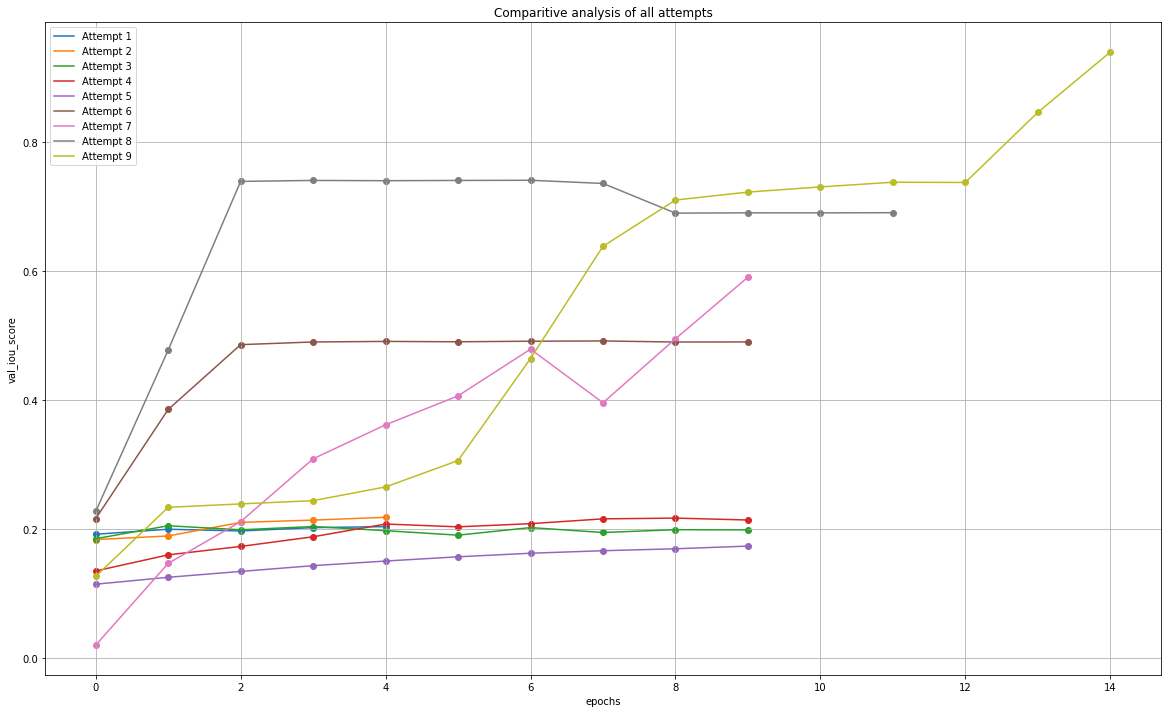

In [78]:
plt.figure(figsize=(20,12))
plt.grid()
for i in range (1,10):
    score=history[f"his_{i}"]["val_iou_score"]
    plt.plot(score, label = f"Attempt {i}")
    plt.scatter(range(len(score)),score)
    plt.legend()
plt.xlabel("epochs")  
plt.ylabel("val_iou_score") 
plt.title("Comparitive analysis of all attempts")
plt.show()

# Description Table

| Attempt No.        | Description                              | Previous val_iou_score | Current val_iou_score |Verdict|
| ----------- | -----------                              | -----------------------|-----------------------|-------|
| 1           | Ran the given notebook without any change.       |        N/A                |    0.204104           |Very low val_iou_score
| 2           | Increased the size H=480 and W=480 so that there is less loss of information.| 0.204104| 0.218500 | No considerable change, val_iou_score increased a bit
| 3           | Increased the number of epochs to 10 to check for improvement.|0.218500               |    0.199019|No considerable change, val_iou_score decreased a bit
| 4           | Increased the batch size from initial 8 to 16 to check the effect. |  0.199019              |    0.214362           |Not much change observed in val_iou_score
| 5           | Decreased the batch size=8 and decreased learning rate from 1e-4 to 1e-5|      0.214362                |   0.173893           |val_iou_score decreased when learning rate was decreased
| 6           |Implemented Transfer Learning using vgg16 as backbone and epoch=10 and learning rate=1e-5                 | 0.173893                       |0.490566 |val_iou_score increased considerably
|7         |Implemented Transfer Learning using vgg19 as backbone with batch_size=8 and epoch=10|   0.490566| 0.591038|val_iou_score increased    
|8          |Implemented Transfer Learning using vgg16 as backbone with batch_size=8 and epoch=20 also used callbacks.Early stopping occured at epoch=12|0.591038 |0.691028|val_iou_score increased
|9          |Implemented Transfer Learning using vgg19 as backbone with batch_size=16 and epoch=15 and used callbacks |0.691028 |0.940080|val_iou_score increased considerably


# Attempts Details

## a1 h=256 w=256 epoch 5 batch size=8 lr = 1e-4
{'loss': [0.2617684006690979, 0.10576216876506805, 0.07568765431642532, 0.06044408679008484, 0.04954001307487488], 'iou_score': [0.16712434589862823, 0.1976258009672165, 0.2011638730764389, 0.2011171281337738, 0.20293642580509186], 'val_loss': [0.1450260579586029, 0.07722200453281403, 0.07062003761529922, 0.05581265315413475, 0.04299436882138252], 'val_iou_score': [0.19227533042430878, 0.2000545710325241, 0.1973658800125122, 0.20253504812717438, 0.20410369336605072]}

## a2 h=480 w=480 epoch 5 batch size=8 lr = 1e-4
{'loss': [0.31569206714630127, 0.12341804802417755, 0.07231595367193222, 0.054057080298662186, 0.03875035420060158], 'iou_score': [0.15838618576526642, 0.19535671174526215, 0.20605981349945068, 0.21547819674015045, 0.21899272501468658], 'val_loss': [0.17654937505722046, 0.08933157473802567, 0.05859103798866272, 0.053688909858465195, 0.03531716763973236], 'val_iou_score': [0.18403011560440063, 0.18961165845394135, 0.21063950657844543, 0.2142411172389984, 0.21850033104419708]}

## a3 H=480 w=480 epoch 10 batch size=8 lr = 1e-4

{'loss': [0.28708651661872864, 0.10530440509319305, 0.0646548941731453, 0.047289133071899414, 0.03276478499174118, 0.02623555436730385, 0.021300900727510452, 0.017440592870116234, 0.016247835010290146, 0.014054697006940842], 'iou_score': [0.16771677136421204, 0.198370561003685, 0.2027149498462677, 0.2047141194343567, 0.20708298683166504, 0.2031472772359848, 0.20427049696445465, 0.19952161610126495, 0.19979263842105865, 0.2015218734741211], 'val_loss': [0.4317851662635803, 0.08263328671455383, 0.06001194193959236, 0.043167226016521454, 0.018532011657953262, 0.03747168555855751, 0.022318130359053612, 0.013888923451304436, 0.016315804794430733, 0.014644838869571686], 'val_iou_score': [0.18536804616451263, 0.2054387927055359, 0.1991557776927948, 0.20422329008579254, 0.1978335827589035, 0.1908322125673294, 0.2025929093360901, 0.19498558342456818, 0.19930481910705566, 0.19901855289936066]}

## a4 H=480 w=480 epoch 10 batch size =16 lr = 1e-4
{'loss': [0.5943842530250549, 0.3675661087036133, 0.23175053298473358, 0.15445002913475037, 0.10610467940568924, 0.07789969444274902, 0.0653340145945549, 0.05476822704076767, 0.04544506222009659, 0.03849362954497337], 'iou_score': [0.11598598212003708, 0.14835362136363983, 0.17450867593288422, 0.19155435264110565, 0.20388951897621155, 0.21256941556930542, 0.2119280844926834, 0.2144542932510376, 0.21744805574417114, 0.219312384724617], 'val_loss': [0.4030018448829651, 0.30547818541526794, 0.16527417302131653, 0.109162837266922, 0.08847372978925705, 0.05287674441933632, 0.07738141715526581, 0.04512815177440643, 0.04999328404664993, 0.06253092736005783], 'val_iou_score': [0.13534128665924072, 0.16029155254364014, 0.17336510121822357, 0.1883571296930313, 0.20812740921974182, 0.2037612497806549, 0.208674356341362, 0.21613778173923492, 0.217292919754982, 0.2143622487783432]}

## a5 H=480 w=480 epoch 10 batch size =8 lr = 1e-5
{'loss': [0.7005766034126282, 0.5311981439590454, 0.4657116234302521, 0.41605710983276367, 0.3728578984737396, 0.33449047803878784, 0.3004123270511627, 0.2719328999519348, 0.2542559802532196, 0.23253504931926727], 'iou_score': [0.09834833443164825, 0.12074071168899536, 0.1309419721364975, 0.13923493027687073, 0.14677143096923828, 0.15367266535758972, 0.15985436737537384, 0.16508318483829498, 0.16700999438762665, 0.17099952697753906], 'val_loss': [0.5798984169960022, 0.504838228225708, 0.44645535945892334, 0.3913270831108093, 0.3552182912826538, 0.31940728425979614, 0.2835420072078705, 0.2641867995262146, 0.23887622356414795, 0.2227216362953186], 'val_iou_score': [0.11477825045585632, 0.12550748884677887, 0.1345818042755127, 0.14353424310684204, 0.15071600675582886, 0.1572818011045456, 0.16281068325042725, 0.1667112559080124, 0.16972532868385315, 0.17389324307441711]}

## a6 H=480 w=480 epoch 10 vgg16
{'loss': [0.6072426438331604, 0.32495081424713135, 0.21022357046604156, 0.1391284316778183, 0.09245886653661728, 0.06463201344013214, 0.05166522040963173, 0.04066461697220802, 0.03139606863260269, 0.025211308151483536], 'iou_score': [0.17303308844566345, 0.2972007691860199, 0.4672749638557434, 0.4887654781341553, 0.4909071624279022, 0.4913613498210907, 0.4919533431529999, 0.49276793003082275, 0.49231818318367004, 0.4959476888179779], 'f1-score': [0.20568017661571503, 0.3135991394519806, 0.4764620065689087, 0.49421459436416626, 0.4953322410583496, 0.49556905031204224, 0.4959999918937683, 0.4966714084148407, 0.4960664212703705, 0.499923437833786], 'val_loss': [0.39146843552589417, 0.2475631833076477, 0.15662634372711182, 0.11247151345014572, 0.07575240731239319, 0.05379499867558479, 0.042477697134017944, 0.03354738652706146, 0.02937193773686886, 0.02066725306212902], 'val_iou_score': [0.21647900342941284, 0.38579991459846497, 0.48634257912635803, 0.4905140995979309, 0.4913749098777771, 0.49081090092658997, 0.49168750643730164, 0.49206775426864624, 0.49043112993240356, 0.49056559801101685], 'val_f1-score': [0.23521390557289124, 0.39575883746147156, 0.4924508035182953, 0.49513623118400574, 0.49557891488075256, 0.4952799081802368, 0.4957371652126312, 0.4959350526332855, 0.4950726628303528, 0.49614256620407104]}

## a7 H=480 w=480 epoch 10 vgg19
{'loss': [0.9665548801422119, 0.6416874527931213, 0.456417053937912, 0.3419467806816101, 0.265754759311676, 0.2097509652376175, 0.16855792701244354, 0.13813096284866333, 0.11480361968278885, 0.09574946761131287], 'iou_score': [0.01412388775497675, 0.08718226104974747, 0.17821502685546875, 0.2202359139919281, 0.2331342101097107, 0.23777247965335846, 0.24467022716999054, 0.25544992089271545, 0.28190818428993225, 0.3038877844810486], 'f1-score': [0.025940047577023506, 0.12320568412542343, 0.20748990774154663, 0.23402974009513855, 0.24123618006706238, 0.24371083080768585, 0.25001025199890137, 0.26028770208358765, 0.2863427698612213, 0.3081013560295105], 'val_loss': [0.7845720648765564, 0.5378904342651367, 0.3838582932949066, 0.28702297806739807, 0.25052574276924133, 0.1812140792608261, 0.14475442469120026, 0.1265403926372528, 0.10114774107933044, 0.07970298826694489], 'val_iou_score': [0.02024873159825802, 0.14704637229442596, 0.21178075671195984, 0.30926713347435, 0.3620385229587555, 0.4068925082683563, 0.4793839752674103, 0.39618465304374695, 0.4954265356063843, 0.5910382270812988], 'val_f1-score': [0.03733126074075699, 0.18463262915611267, 0.23330560326576233, 0.31911250948905945, 0.36928075551986694, 0.4123165011405945, 0.484442800283432, 0.40085065364837646, 0.49966961145401, 0.5965915322303772]}

## a8 epoch 20 vgg16 batch size=8
{'loss': [0.4944688677787781, 0.24267591536045074, 0.1654891073703766, 0.11082589626312256, 0.07593882828950882, 0.05236826464533806, 0.03835173696279526, 0.02920622006058693, 0.026087315753102303, 0.02136596105992794, 0.017417218536138535, 0.015489734709262848], 'iou_score': [0.15982545912265778, 0.3326340615749359, 0.6961107850074768, 0.7401086688041687, 0.7409684658050537, 0.7414711713790894, 0.7413363456726074, 0.7429677844047546, 0.7098744511604309, 0.6947212815284729, 0.6980855464935303, 0.6997924447059631], 'f1-score': [0.18846042454242706, 0.3399449288845062, 0.7018640041351318, 0.7449160814285278, 0.7453656792640686, 0.7456263303756714, 0.7455536127090454, 0.7479904294013977, 0.7309619188308716, 0.7187503576278687, 0.7209342122077942, 0.7218531966209412], 'val_loss': [0.3011381924152374, 0.24073989689350128, 0.1386190950870514, 0.08836644142866135, 0.06178855895996094, 0.03873889148235321, 0.032877255231142044, 0.02473745122551918, 0.023754116147756577, 0.018496353179216385, 0.014868027530610561, 0.014875520020723343], 'val_iou_score': [0.2276405245065689, 0.4780097007751465, 0.7395776510238647, 0.7410569787025452, 0.7406447529792786, 0.7410573959350586, 0.7413222789764404, 0.7363978624343872, 0.6903530359268188, 0.6908197999000549, 0.690765380859375, 0.6910279989242554], 'val_f1-score': [0.23823796212673187, 0.4901692271232605, 0.74463951587677, 0.7454102039337158, 0.745190441608429, 0.745413064956665, 0.7455527782440186, 0.7429729700088501, 0.715924084186554, 0.7162433862686157, 0.7162012457847595, 0.7163606286048889], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-06]}

## a9 epoch 15 vgg19 batch size 16
{'loss': [0.7329406142234802, 0.38040846586227417, 0.25468748807907104, 0.17912985384464264, 0.13309232890605927, 0.10665001720190048, 0.08650507032871246, 0.06708993017673492, 0.053351979702711105, 0.04333120584487915, 0.03569931536912918, 0.030224453657865524, 0.026120662689208984, 0.024284066632390022, 0.02406151220202446], 'iou_score': [0.08543857932090759, 0.21568571031093597, 0.23640523850917816, 0.23923850059509277, 0.24050574004650116, 0.28844714164733887, 0.42375147342681885, 0.5760417580604553, 0.6907337307929993, 0.7292898893356323, 0.7365297675132751, 0.7389060258865356, 0.7405415773391724, 0.8038293123245239, 0.9155140519142151], 'f1-score': [0.12097746878862381, 0.2311827838420868, 0.24298733472824097, 0.2444808930158615, 0.24514102935791016, 0.2929389178752899, 0.4279714822769165, 0.5801954865455627, 0.6949162483215332, 0.7334083914756775, 0.7406165599822998, 0.7430811524391174, 0.7449178099632263, 0.8157926201820374, 0.9389850497245789], 'val_loss': [0.5148770213127136, 0.2928008437156677, 0.19890817999839783, 0.14705216884613037, 0.11529620736837387, 0.09514972567558289, 0.078372061252594, 0.05615273118019104, 0.04717196524143219, 0.04115479812026024, 0.03467915207147598, 0.02581498771905899, 0.0239594504237175, 0.02342778816819191, 0.021380456164479256], 'val_iou_score': [0.1269662231206894, 0.23406650125980377, 0.23931077122688293, 0.24439401924610138, 0.2656588554382324, 0.30654165148735046, 0.4648556709289551, 0.6389114260673523, 0.710667073726654, 0.7229757905006409, 0.7310060858726501, 0.7382761240005493, 0.7379210591316223, 0.8466430306434631, 0.9400798082351685], 'val_f1-score': [0.16807901859283447, 0.24174915254116058, 0.24452145397663116, 0.24913623929023743, 0.27002614736557007, 0.3109544813632965, 0.4690181016921997, 0.6431347131729126, 0.714874267578125, 0.7271777987480164, 0.7352862358093262, 0.7429987788200378, 0.7428148984909058, 0.8713915348052979, 0.9651384949684143], 'lr': [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]}

---
# <center> THE END